In [81]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve,
    classification_report
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from pytorch_tabnet.tab_model import TabNetClassifier
SEED = 42

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


# 1) Load Data

In [82]:
CSV_PATH = "processed_clean_data.csv"
df = pd.read_csv(CSV_PATH)

# Target + features
y = df["PASS_FAIL"].astype(int).values
X = df.drop(["PASS_FAIL", "TARGET"], axis=1)

feature_names = X.columns.tolist()
X = X.values

print("Raw shape X:", X.shape, "y:", y.shape)
print("Class distribution (counts):", np.bincount(y))
print("Class distribution (ratio):", np.bincount(y) / len(y))


Raw shape X: (25260, 67) y: (25260,)
Class distribution (counts): [ 9951 15309]
Class distribution (ratio): [0.39394299 0.60605701]


# 2) Stratified Train/Test Split

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=SEED,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train dist:", np.bincount(y_train), "Test dist:", np.bincount(y_test))

Train shape: (20208, 67) Test shape: (5052, 67)
Train dist: [ 7961 12247] Test dist: [1990 3062]


# 3) Common evaluation helpers

In [84]:
def compute_metrics(y_true, y_pred, y_proba):
    """
    y_true: (n,)
    y_pred: (n,) 0/1
    y_proba: (n,) probability of class 1
    """
    out = {}
    out["Accuracy"] = accuracy_score(y_true, y_pred)
    out["Balanced_Accuracy"] = balanced_accuracy_score(y_true, y_pred)
    out["Precision"] = precision_score(y_true, y_pred, zero_division=0)
    out["Recall"] = recall_score(y_true, y_pred, zero_division=0)
    out["F1"] = f1_score(y_true, y_pred, zero_division=0)

    # ROC-AUC requires probabilities and both classes present
    try:
        out["ROC_AUC"] = roc_auc_score(y_true, y_proba)
    except ValueError:
        out["ROC_AUC"] = np.nan

    return out


def per_class_table_from_report(report_dict, model_name):
    """
    Takes sklearn classification_report(output_dict=True).
    Returns DataFrame with class-wise precision/recall/f1/support.
    """
    rows = []
    for cls in ["0", "1"]:
        if cls in report_dict:
            rows.append([
                model_name,
                int(cls),
                report_dict[cls]["precision"],
                report_dict[cls]["recall"],
                report_dict[cls]["f1-score"],
                report_dict[cls]["support"]
            ])
    return pd.DataFrame(
        rows,
        columns=["Model", "Class", "Precision", "Recall", "F1", "Support"]
    )


def plot_roc_curves(roc_items, title="ROC Curves (Test Set)"):
    """
    roc_items: list of tuples (label, y_true, y_proba)
    """
    plt.figure(figsize=(8, 6))
    for label, yt, yp in roc_items:
        fpr, tpr, _ = roc_curve(yt, yp)
        try:
            auc = roc_auc_score(yt, yp)
        except ValueError:
            auc = np.nan
        plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.4f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# BASELINE MODELS

In [85]:
overall_rows = []
classwise_rows = []
roc_items = []

def classwise_df(report, model_name):
    rows = []
    for cls in ["0", "1"]:
        rows.append([
            model_name,
            int(cls),
            report[cls]["precision"],
            report[cls]["recall"],
            report[cls]["f1-score"],
            report[cls]["support"]
        ])
    return pd.DataFrame(
        rows,
        columns=["Model", "Class", "Precision", "Recall", "F1", "Support"]
    )



## KNN

In [86]:
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)
knn_proba = knn_pipe.predict_proba(X_test)[:, 1]

knn_metrics = compute_metrics(y_test, knn_pred, knn_proba)
overall_rows.append(["KNN (Baseline)", *knn_metrics.values()])

knn_report = classification_report(y_test, knn_pred, output_dict=True, zero_division=0)
classwise_rows.append(classwise_df(knn_report, "KNN (Baseline)"))

roc_items.append(("KNN (Baseline)", y_test, knn_proba))

## Naive Bayes

In [87]:
nb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GaussianNB())
])

nb_pipe.fit(X_train, y_train)
nb_pred = nb_pipe.predict(X_test)
nb_proba = nb_pipe.predict_proba(X_test)[:, 1]

nb_metrics = compute_metrics(y_test, nb_pred, nb_proba)
overall_rows.append(["Naive Bayes (Baseline)", *nb_metrics.values()])

nb_report = classification_report(y_test, nb_pred, output_dict=True, zero_division=0)
classwise_rows.append(classwise_df(nb_report, "Naive Bayes (Baseline)"))

roc_items.append(("Naive Bayes (Baseline)", y_test, nb_proba))


# 4) Model #1: GRU (PyTorch) for tabular

## 4.1) Preprocess for GRU: Impute + Scale

In [88]:
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

n_features = X_train_scaled.shape[1]
print("GRU n_features:", n_features)

# reshape to (N, seq_len, 1)
X_train_gru = X_train_scaled.reshape(-1, n_features, 1).astype(np.float32)
X_test_gru  = X_test_scaled.reshape(-1, n_features, 1).astype(np.float32)


GRU n_features: 67


## 4.2) Torch Dataset + Loader

In [89]:
class TabularSeqDataset(Dataset):
    def __init__(self, X_seq, y):
        self.X = torch.tensor(X_seq, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 256

train_ds = TabularSeqDataset(X_train_gru, y_train)
test_ds  = TabularSeqDataset(X_test_gru, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

## 4.3) GRU Model

In [90]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)  # binary logit
        )

    def forward(self, x):
        # x: (B, seq_len, 1)
        out, _ = self.gru(x)          # out: (B, seq_len, hidden)
        last = out[:, -1, :]          # take last step
        logit = self.head(last)       # (B, 1)
        return logit.squeeze(1)       # (B,)

# class imbalance handling via pos_weight
# pos_weight = (#neg / #pos)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)

gru_model = GRUClassifier(input_size=1, hidden_size=128, num_layers=2, dropout=0.25).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(gru_model.parameters(), lr=1e-3, weight_decay=1e-4)


## 4.4) Train loop with Early Stopping

In [91]:
def evaluate_gru(model, loader):
    model.eval()
    all_logits = []
    all_y = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_y.append(yb.detach().cpu().numpy())
    all_logits = np.concatenate(all_logits)
    all_y = np.concatenate(all_y)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid
    preds = (probs >= 0.5).astype(int)
    return all_y.astype(int), preds, probs

def train_gru(model, train_loader, val_loader, epochs=30, patience=6):
    best_auc = -1
    best_state = None
    wait = 0

    for ep in range(1, epochs + 1):
        model.train()
        losses = []
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            losses.append(loss.item())

        # validate on test_loader (you can also make a separate val split)
        y_true, y_pred, y_proba = evaluate_gru(model, val_loader)
        try:
            auc = roc_auc_score(y_true, y_proba)
        except ValueError:
            auc = np.nan

        print(f"Epoch {ep:02d} | loss={np.mean(losses):.4f} | val_auc={auc:.4f}")

        if np.isnan(auc):
            # if AUC can't be computed, fall back to F1
            f1v = f1_score(y_true, y_pred, zero_division=0)
            score = f1v
        else:
            score = auc

        if score > best_auc:
            best_auc = score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# Train GRU
gru_model = train_gru(gru_model, train_loader, test_loader, epochs=30, patience=6)

# Final GRU test eval
gru_y_true, gru_y_pred, gru_y_proba = evaluate_gru(gru_model, test_loader)
gru_metrics = compute_metrics(gru_y_true, gru_y_pred, gru_y_proba)
print("\n=== GRU (PyTorch) Test Metrics ===")
for k, v in gru_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nConfusion Matrix (GRU):\n", confusion_matrix(gru_y_true, gru_y_pred))
print("\nClassification Report (GRU):\n", classification_report(gru_y_true, gru_y_pred))


Epoch 01 | loss=0.5354 | val_auc=0.6487
Epoch 02 | loss=0.5270 | val_auc=0.6686
Epoch 03 | loss=0.4926 | val_auc=0.8153
Epoch 04 | loss=0.3498 | val_auc=0.9360
Epoch 05 | loss=0.2476 | val_auc=0.9559
Epoch 06 | loss=0.2103 | val_auc=0.9708
Epoch 07 | loss=0.1758 | val_auc=0.9741
Epoch 08 | loss=0.1650 | val_auc=0.9749
Epoch 09 | loss=0.1613 | val_auc=0.9762
Epoch 10 | loss=0.1531 | val_auc=0.9800
Epoch 11 | loss=0.1481 | val_auc=0.9813
Epoch 12 | loss=0.1425 | val_auc=0.9816
Epoch 13 | loss=0.1345 | val_auc=0.9831
Epoch 14 | loss=0.1302 | val_auc=0.9835
Epoch 15 | loss=0.1208 | val_auc=0.9850
Epoch 16 | loss=0.1188 | val_auc=0.9860
Epoch 17 | loss=0.1144 | val_auc=0.9820
Epoch 18 | loss=0.1137 | val_auc=0.9856
Epoch 19 | loss=0.1045 | val_auc=0.9876
Epoch 20 | loss=0.1015 | val_auc=0.9865
Epoch 21 | loss=0.1003 | val_auc=0.9876
Epoch 22 | loss=0.0964 | val_auc=0.9882
Epoch 23 | loss=0.0951 | val_auc=0.9884
Epoch 24 | loss=0.0910 | val_auc=0.9881
Epoch 25 | loss=0.0912 | val_auc=0.9874


# 6) Model #2: TabNet (PyTorch TabNet)

In [96]:
# TabNet expects numpy float32 and targets int (numpy)
X_train_tabnet = X_train_imp.astype(np.float32)
X_test_tabnet  = X_test_imp.astype(np.float32)

y_train_tabnet = y_train.astype(int)
y_test_tabnet  = y_test.astype(int)

# ---- sample weights (length == n_train) ----
neg = (y_train_tabnet == 0).sum()
pos = (y_train_tabnet == 1).sum()

w0 = 1.0
w1 = neg / max(pos, 1)  # heavier weight for minority class (1)
sample_weights = np.where(y_train_tabnet == 1, w1, w0).astype(np.float32)

print("Shapes:",
      "X_train", X_train_tabnet.shape,
      "y_train", y_train_tabnet.shape,
      "weights", sample_weights.shape)

# TabNet basic config (you can tune these)
tabnet = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax",
    seed=SEED,
    verbose=10,
    device_name="cuda" if torch.cuda.is_available() else "cpu"
)

tabnet.fit(
    X_train_tabnet, y_train_tabnet,
    eval_set=[(X_test_tabnet, y_test_tabnet)],
    eval_name=["test"],
    eval_metric=["auc"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=sample_weights  # ✅ correct for your version
)

tabnet_proba = tabnet.predict_proba(X_test_tabnet)[:, 1]
tabnet_pred  = (tabnet_proba >= 0.5).astype(int)

tabnet_metrics = compute_metrics(y_test_tabnet, tabnet_pred, tabnet_proba)
print("\n=== TabNet (PyTorch) Test Metrics ===")
for k, v in tabnet_metrics.items():
    print(f"{k}: {v:.4f}")

from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion Matrix (TabNet):\n", confusion_matrix(y_test_tabnet, tabnet_pred))
print("\nClassification Report (TabNet):\n", classification_report(y_test_tabnet, tabnet_pred, zero_division=0))

Shapes: X_train (20208, 67) y_train (20208,) weights (20208,)


c:\Users\ameen\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71448 | test_auc: 0.73012 |  0:00:02s
epoch 10 | loss: 0.1644  | test_auc: 0.97793 |  0:00:26s
epoch 20 | loss: 0.14515 | test_auc: 0.98467 |  0:00:48s
epoch 30 | loss: 0.14571 | test_auc: 0.98436 |  0:01:10s
epoch 40 | loss: 0.14394 | test_auc: 0.98446 |  0:01:32s
epoch 50 | loss: 0.13939 | test_auc: 0.98552 |  0:01:55s
epoch 60 | loss: 0.14085 | test_auc: 0.98324 |  0:02:18s

Early stopping occurred at epoch 67 with best_epoch = 47 and best_test_auc = 0.98595


c:\Users\ameen\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet (PyTorch) Test Metrics ===
Accuracy: 0.9622
Balanced_Accuracy: 0.9579
Precision: 0.9602
Recall: 0.9781
F1: 0.9691
ROC_AUC: 0.9860

Confusion Matrix (TabNet):
 [[1866  124]
 [  67 2995]]

Classification Report (TabNet):
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      1990
           1       0.96      0.98      0.97      3062

    accuracy                           0.96      5052
   macro avg       0.96      0.96      0.96      5052
weighted avg       0.96      0.96      0.96      5052



# 7) Build Required Tables (Overall + Class-wise)

In [97]:
overall_rows = []
overall_rows.append(["GRU (PyTorch)", *[gru_metrics[m] for m in ["Accuracy","Balanced_Accuracy","Precision","Recall","F1","ROC_AUC"]]])
overall_rows.append(["TabNet (PyTorch)", *[tabnet_metrics[m] for m in ["Accuracy","Balanced_Accuracy","Precision","Recall","F1","ROC_AUC"]]])

overall_df = pd.DataFrame(
    overall_rows,
    columns=["Model","Accuracy","Balanced_Accuracy","Precision","Recall","F1","ROC_AUC"]
)

# class-wise
gru_report = classification_report(gru_y_true, gru_y_pred, output_dict=True, zero_division=0)
tabnet_report = classification_report(y_test_tabnet, tabnet_pred, output_dict=True, zero_division=0)

classwise_df = pd.concat([
    per_class_table_from_report(gru_report, "GRU (PyTorch)"),
    per_class_table_from_report(tabnet_report, "TabNet (PyTorch)")
], ignore_index=True)

print("\n=== OVERALL COMPARISON (Test) ===")
display(overall_df)

print("\n=== CLASS-WISE COMPARISON (Test) ===")
display(classwise_df)




=== OVERALL COMPARISON (Test) ===


,Model,Accuracy,Balanced_Accuracy,Precision,Recall,F1,ROC_AUC
0,GRU (PyTorch),0.962193,0.958256,0.961427,0.976813,0.969059,0.988935
1,TabNet (PyTorch),0.962193,0.957904,0.960244,0.978119,0.969099,0.985953



=== CLASS-WISE COMPARISON (Test) ===


,Model,Class,Precision,Recall,F1,Support
0,GRU (PyTorch),0,0.963421,0.939698,0.951412,1990.0
1,GRU (PyTorch),1,0.961427,0.976813,0.969059,3062.0
2,TabNet (PyTorch),0,0.965339,0.937688,0.951313,1990.0
3,TabNet (PyTorch),1,0.960244,0.978119,0.969099,3062.0


# 8) ROC Curves 

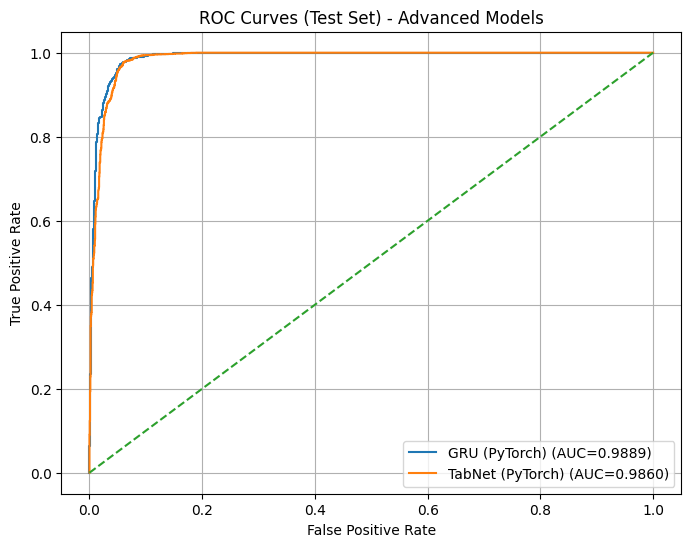

In [98]:
roc_items = [
    ("GRU (PyTorch)", gru_y_true, gru_y_proba),
    ("TabNet (PyTorch)", y_test_tabnet, tabnet_proba),
]
plot_roc_curves(roc_items, title="ROC Curves (Test Set) - Advanced Models")


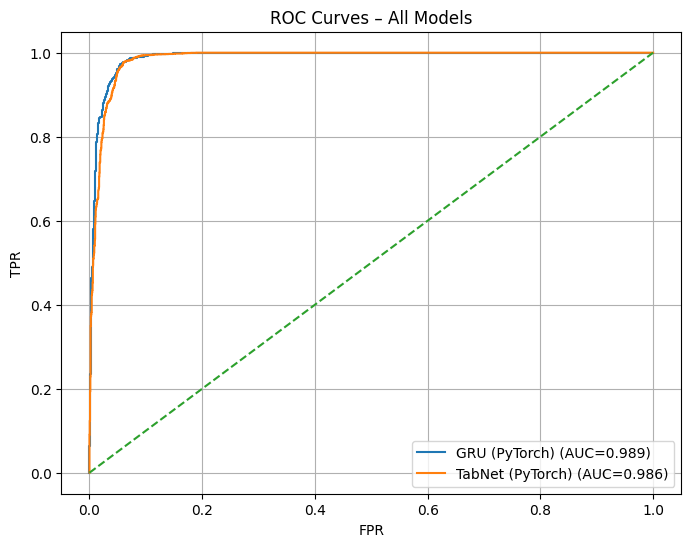

In [99]:
plt.figure(figsize=(8,6))
for name, yt, yp in roc_items:
    fpr, tpr, _ = roc_curve(yt, yp)
    auc = roc_auc_score(yt, yp)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves – All Models")
plt.legend()
plt.grid()
plt.show()

## FINAL TABLES

In [100]:
overall_df = pd.DataFrame(
    overall_rows,
    columns=[
        "Model","Accuracy","Balanced_Accuracy",
        "Precision","Recall","F1","ROC_AUC"
    ]
)

classwise_df = pd.concat(classwise_rows, ignore_index=True)

print("\n=== OVERALL COMPARISON ===")
display(overall_df)

print("\n=== CLASS-WISE COMPARISON ===")
display(classwise_df)


=== OVERALL COMPARISON ===


,Model,Accuracy,Balanced_Accuracy,Precision,Recall,F1,ROC_AUC
0,GRU (PyTorch),0.962193,0.958256,0.961427,0.976813,0.969059,0.988935
1,TabNet (PyTorch),0.962193,0.957904,0.960244,0.978119,0.969099,0.985953



=== CLASS-WISE COMPARISON ===


,Model,Class,Precision,Recall,F1,Support
0,KNN (Baseline),0,0.895297,0.803518,0.846928,1990.0
1,KNN (Baseline),1,0.880282,0.938929,0.908660,3062.0
2,Naive Bayes (Baseline),0,0.815440,0.801508,0.808414,1990.0
3,Naive Bayes (Baseline),1,0.872416,0.882103,0.877233,3062.0
